## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import squidpy as sq

In [2]:
import models
import metrics
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#sc.set_figure_params(scanpy=True, fontsize=16)


In [3]:
adata = sq.datasets.merfish()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 73642 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts'
    uns: 'Cell_class_colors', 'log1p'
    obsm: 'spatial', 'spatial3d'

In [4]:
adata.obs['Cell_class'].value_counts()

Inhibitory       24761
Excitatory       11757
Ambiguous         9269
Astrocyte         8393
OD Mature 2       5736
Endothelial 1     3799
OD Immature 1     2457
Ependymal         1961
Microglia         1472
Endothelial 3     1369
OD Mature 1        952
Pericytes          638
Endothelial 2      581
OD Mature 4        367
OD Immature 2       91
OD Mature 3         39
Name: Cell_class, dtype: int64

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


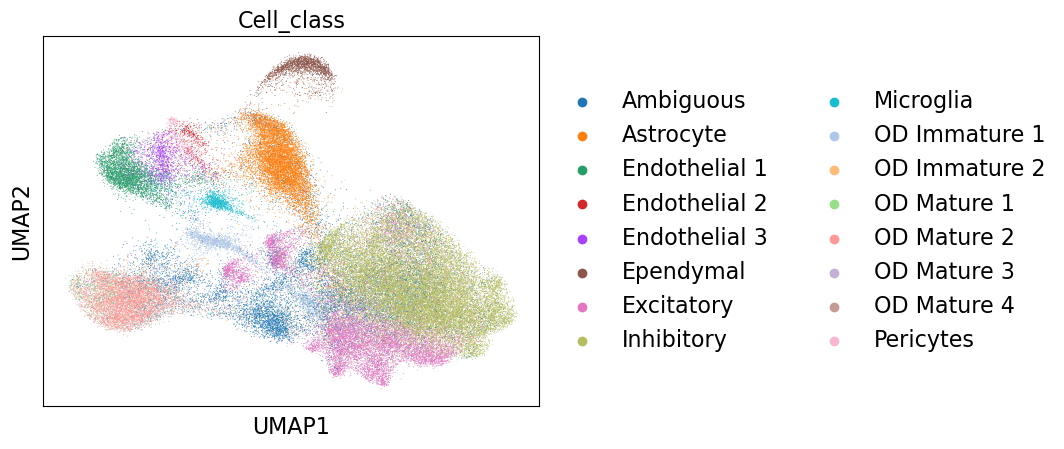

In [5]:
import squidpy as sq
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='Cell_class')

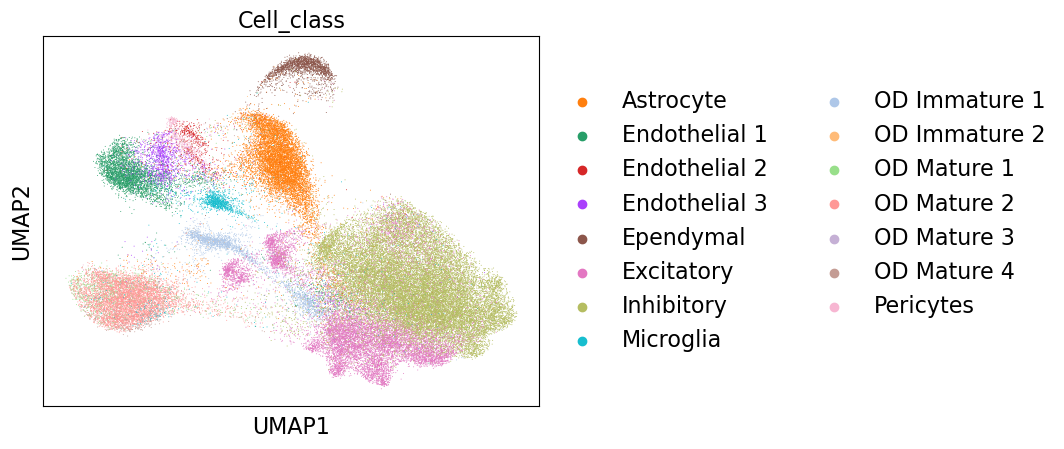

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


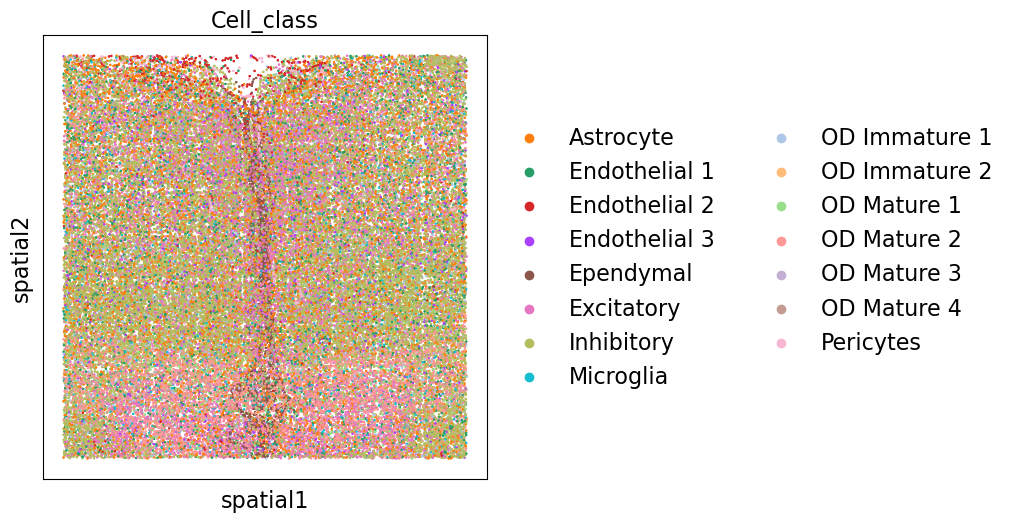

In [6]:
adata= adata[adata.obs['Cell_class'].isin(['OD Mature 2',
 'OD Immature 1',
 'Inhibitory',
 'Excitatory',
 'Microglia',
 'Astrocyte',
 'Endothelial 2',
 'Endothelial 3',
 'Endothelial 1',
 'OD Mature 1',
 'OD Mature 4',
 'Pericytes',
 'OD Mature 3',
 'Ependymal',
 'OD Immature 2']
)]
sc.pl.umap(adata,color='Cell_class')
sq.pl.spatial_scatter(
    adata, color="Cell_class", shape=None, figsize=(10, 10)
)

In [7]:
import numpy as np

# Define a dictionary to map each cluster to its corresponding cell type
cell_type_mapping = {
    'OD Mature 2': 'OD Mature',
    'OD Immature 1': 'OD Immature',
    'Inhibitory': 'Inhibitory',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Astrocyte': 'Astrocyte',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Endothelial 1': 'Endothelial',
    'OD Mature 1': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes',
    'OD Mature 3': 'OD Mature',
    'Ependymal': 'Ependymal',
    'OD Immature 2': 'OD Immature'
}

# Create an empty list to store the updated cell types
cell_type_list = []

# Iterate over each cluster and assign the corresponding cell type
for i in range(adata.n_obs):
    cluster_name = adata.obs['Cell_class'][i]
    if cluster_name in cell_type_mapping:
        cell_type_list.append(cell_type_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['CellType'] = np.array(cell_type_list)


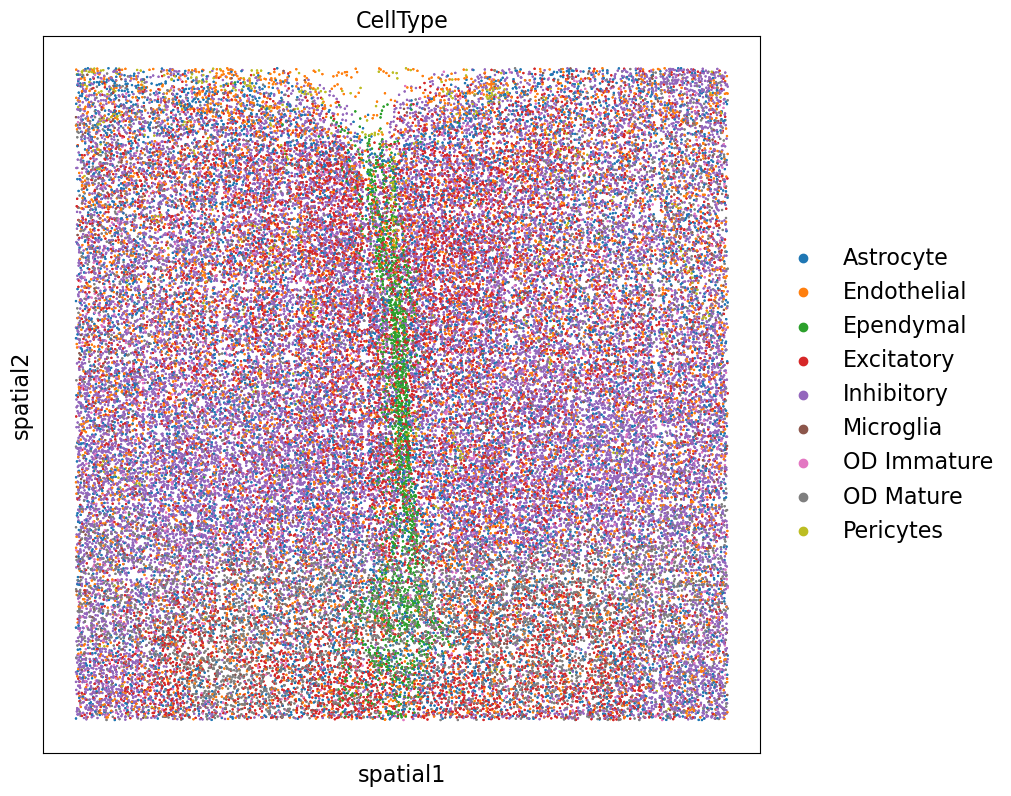

In [8]:
sq.pl.spatial_scatter(
    adata, color="CellType", shape=None, figsize=(10, 10)
)


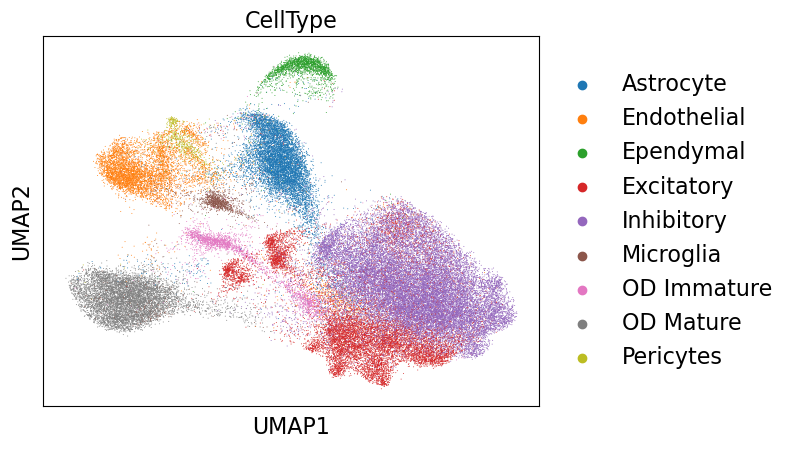

In [9]:
sc.pl.umap(adata,color='CellType')

In [10]:
len(set(adata.obs['CellType']))

9

In [11]:
adata.obsm['spatial']

array([[0.00906344, 0.08041869],
       [0.03281294, 0.09883481],
       [0.04015782, 0.07502649],
       ...,
       [0.93928628, 0.88763104],
       [0.97045268, 0.88984304],
       [0.99918989, 0.94175804]])

In [12]:
epoch_num=20
prob_list = models.follow_training_dyn_neural_net(adata, label_key='CellType',iterNum=epoch_num, device=device, batch_size=64)
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
adata.obs["var"] = all_var.detach().numpy()
adata.obs["conf"] = all_conf.detach().numpy()



/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.452
[1,    12] loss: 2.225
[1,    22] loss: 2.177
[1,    32] loss: 2.133
[1,    42] loss: 2.084
[1,    52] loss: 2.037
[1,    62] loss: 1.998
[1,    72] loss: 1.925
[1,    82] loss: 1.881
[1,    92] loss: 1.813
[1,   102] loss: 1.730
[1,   112] loss: 1.647
[1,   122] loss: 1.554
[1,   132] loss: 1.464
[1,   142] loss: 1.371
[1,   152] loss: 1.261
[1,   162] loss: 1.173
[1,   172] loss: 1.093
[1,   182] loss: 0.979
[1,   192] loss: 0.908
[1,   202] loss: 0.856
[1,   212] loss: 0.795
[1,   222] loss: 0.728
[1,   232] loss: 0.701
[1,   242] loss: 0.664
[1,   252] loss: 0.576
[1,   262] loss: 0.599
[1,   272] loss: 0.542
[1,   282] loss: 0.517
[1,   292] loss: 0.468
[1,   302] loss: 0.475
[1,   312] loss: 0.468
[1,   322] loss: 0.436
[1,   332] loss: 0.432
[1,   342] loss: 0.424
[1,   352] loss: 0.430
[1,   362] loss: 0.451
[1,   372] loss: 0.401
[1,   382] loss: 0.398
[1,   392] loss: 0.335
[1,   402] loss: 0.422
[1,   412] loss: 0.356
[1,   422] loss: 0.370
[1,   432] 

[4,   582] loss: 0.209
[4,   592] loss: 0.202
[4,   602] loss: 0.199
[4,   612] loss: 0.174
[4,   622] loss: 0.150
[4,   632] loss: 0.200
[4,   642] loss: 0.213
[4,   652] loss: 0.169
[4,   662] loss: 0.173
[4,   672] loss: 0.142
[4,   682] loss: 0.195
[4,   692] loss: 0.144
[4,   702] loss: 0.223
[4,   712] loss: 0.128
[4,   722] loss: 0.216
[4,   732] loss: 0.184
[4,   742] loss: 0.226
[4,   752] loss: 0.143
[4,   762] loss: 0.183
[4,   772] loss: 0.179
[4,   782] loss: 0.161
[4,   792] loss: 0.176
[4,   802] loss: 0.213
[4,   812] loss: 0.209
[4,   822] loss: 0.203
[4,   832] loss: 0.173
[4,   842] loss: 0.192
[4,   852] loss: 0.185
[4,   862] loss: 0.142
[4,   872] loss: 0.166
[4,   882] loss: 0.166
[4,   892] loss: 0.169
[4,   902] loss: 0.159
[4,   912] loss: 0.190
[4,   922] loss: 0.154
[4,   932] loss: 0.160
[4,   942] loss: 0.196
[4,   952] loss: 0.215
[4,   962] loss: 0.199
[4,   972] loss: 0.168
[4,   982] loss: 0.212
[4,   992] loss: 0.172
[4,  1002] loss: 0.166
[5,     2] 

[8,   172] loss: 0.162
[8,   182] loss: 0.176
[8,   192] loss: 0.189
[8,   202] loss: 0.158
[8,   212] loss: 0.170
[8,   222] loss: 0.136
[8,   232] loss: 0.213
[8,   242] loss: 0.143
[8,   252] loss: 0.165
[8,   262] loss: 0.207
[8,   272] loss: 0.144
[8,   282] loss: 0.143
[8,   292] loss: 0.184
[8,   302] loss: 0.149
[8,   312] loss: 0.154
[8,   322] loss: 0.194
[8,   332] loss: 0.188
[8,   342] loss: 0.173
[8,   352] loss: 0.204
[8,   362] loss: 0.142
[8,   372] loss: 0.172
[8,   382] loss: 0.161
[8,   392] loss: 0.211
[8,   402] loss: 0.137
[8,   412] loss: 0.091
[8,   422] loss: 0.158
[8,   432] loss: 0.131
[8,   442] loss: 0.191
[8,   452] loss: 0.171
[8,   462] loss: 0.143
[8,   472] loss: 0.142
[8,   482] loss: 0.202
[8,   492] loss: 0.220
[8,   502] loss: 0.158
[8,   512] loss: 0.168
[8,   522] loss: 0.201
[8,   532] loss: 0.150
[8,   542] loss: 0.210
[8,   552] loss: 0.168
[8,   562] loss: 0.198
[8,   572] loss: 0.173
[8,   582] loss: 0.155
[8,   592] loss: 0.191
[8,   602] 

[11,   772] loss: 0.144
[11,   782] loss: 0.143
[11,   792] loss: 0.155
[11,   802] loss: 0.162
[11,   812] loss: 0.087
[11,   822] loss: 0.199
[11,   832] loss: 0.133
[11,   842] loss: 0.154
[11,   852] loss: 0.142
[11,   862] loss: 0.118
[11,   872] loss: 0.146
[11,   882] loss: 0.139
[11,   892] loss: 0.168
[11,   902] loss: 0.154
[11,   912] loss: 0.137
[11,   922] loss: 0.179
[11,   932] loss: 0.159
[11,   942] loss: 0.166
[11,   952] loss: 0.127
[11,   962] loss: 0.164
[11,   972] loss: 0.154
[11,   982] loss: 0.192
[11,   992] loss: 0.164
[11,  1002] loss: 0.153
[12,     2] loss: 0.035
[12,    12] loss: 0.128
[12,    22] loss: 0.121
[12,    32] loss: 0.163
[12,    42] loss: 0.166
[12,    52] loss: 0.156
[12,    62] loss: 0.132
[12,    72] loss: 0.151
[12,    82] loss: 0.117
[12,    92] loss: 0.159
[12,   102] loss: 0.151
[12,   112] loss: 0.162
[12,   122] loss: 0.165
[12,   132] loss: 0.166
[12,   142] loss: 0.144
[12,   152] loss: 0.142
[12,   162] loss: 0.166
[12,   172] loss

[15,   182] loss: 0.147
[15,   192] loss: 0.129
[15,   202] loss: 0.164
[15,   212] loss: 0.138
[15,   222] loss: 0.126
[15,   232] loss: 0.153
[15,   242] loss: 0.092
[15,   252] loss: 0.153
[15,   262] loss: 0.136
[15,   272] loss: 0.113
[15,   282] loss: 0.144
[15,   292] loss: 0.120
[15,   302] loss: 0.146
[15,   312] loss: 0.113
[15,   322] loss: 0.127
[15,   332] loss: 0.141
[15,   342] loss: 0.120
[15,   352] loss: 0.163
[15,   362] loss: 0.157
[15,   372] loss: 0.121
[15,   382] loss: 0.114
[15,   392] loss: 0.139
[15,   402] loss: 0.124
[15,   412] loss: 0.110
[15,   422] loss: 0.181
[15,   432] loss: 0.158
[15,   442] loss: 0.128
[15,   452] loss: 0.155
[15,   462] loss: 0.165
[15,   472] loss: 0.128
[15,   482] loss: 0.142
[15,   492] loss: 0.109
[15,   502] loss: 0.146
[15,   512] loss: 0.188
[15,   522] loss: 0.138
[15,   532] loss: 0.116
[15,   542] loss: 0.151
[15,   552] loss: 0.127
[15,   562] loss: 0.111
[15,   572] loss: 0.171
[15,   582] loss: 0.121
[15,   592] loss

[18,   612] loss: 0.115
[18,   622] loss: 0.114
[18,   632] loss: 0.107
[18,   642] loss: 0.104
[18,   652] loss: 0.146
[18,   662] loss: 0.128
[18,   672] loss: 0.097
[18,   682] loss: 0.136
[18,   692] loss: 0.154
[18,   702] loss: 0.146
[18,   712] loss: 0.149
[18,   722] loss: 0.110
[18,   732] loss: 0.123
[18,   742] loss: 0.102
[18,   752] loss: 0.110
[18,   762] loss: 0.124
[18,   772] loss: 0.126
[18,   782] loss: 0.109
[18,   792] loss: 0.173
[18,   802] loss: 0.121
[18,   812] loss: 0.112
[18,   822] loss: 0.140
[18,   832] loss: 0.131
[18,   842] loss: 0.134
[18,   852] loss: 0.122
[18,   862] loss: 0.134
[18,   872] loss: 0.135
[18,   882] loss: 0.109
[18,   892] loss: 0.097
[18,   902] loss: 0.118
[18,   912] loss: 0.106
[18,   922] loss: 0.113
[18,   932] loss: 0.135
[18,   942] loss: 0.133
[18,   952] loss: 0.132
[18,   962] loss: 0.121
[18,   972] loss: 0.113
[18,   982] loss: 0.106
[18,   992] loss: 0.130
[18,  1002] loss: 0.111
[19,     2] loss: 0.030
[19,    12] loss

In [13]:
cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'CellType',device,probability=0.05,percentile=90,epoch_num=epoch_num)
cutoff_conf , cutoff_var

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.449
[1,    12] loss: 2.218
[1,    22] loss: 2.194
[1,    32] loss: 2.168
[1,    42] loss: 2.128
[1,    52] loss: 2.104
[1,    62] loss: 2.068
[1,    72] loss: 2.045
[1,    82] loss: 2.006
[1,    92] loss: 1.962
[1,   102] loss: 1.920
[1,   112] loss: 1.877
[1,   122] loss: 1.808
[1,   132] loss: 1.761
[1,   142] loss: 1.691
[1,   152] loss: 1.652
[1,   162] loss: 1.575
[1,   172] loss: 1.533
[1,   182] loss: 1.494
[1,   192] loss: 1.422
[1,   202] loss: 1.385
[1,   212] loss: 1.336
[1,   222] loss: 1.293
[1,   232] loss: 1.227
[1,   242] loss: 1.233
[1,   252] loss: 1.160
[2,     2] loss: 0.220
[2,    12] loss: 1.128
[2,    22] loss: 1.096
[2,    32] loss: 1.069
[2,    42] loss: 1.082
[2,    52] loss: 1.066
[2,    62] loss: 1.048
[2,    72] loss: 0.976
[2,    82] loss: 0.981
[2,    92] loss: 0.973
[2,   102] loss: 0.957
[2,   112] loss: 0.967
[2,   122] loss: 0.928
[2,   132] loss: 0.913
[2,   142] loss: 0.940
[2,   152] loss: 0.878
[2,   162] loss: 0.914
[2,   172] 

[14,   212] loss: 0.714
[14,   222] loss: 0.727
[14,   232] loss: 0.687
[14,   242] loss: 0.746
[14,   252] loss: 0.719
[15,     2] loss: 0.140
[15,    12] loss: 0.684
[15,    22] loss: 0.710
[15,    32] loss: 0.754
[15,    42] loss: 0.704
[15,    52] loss: 0.739
[15,    62] loss: 0.732
[15,    72] loss: 0.708
[15,    82] loss: 0.717
[15,    92] loss: 0.692
[15,   102] loss: 0.677
[15,   112] loss: 0.735
[15,   122] loss: 0.708
[15,   132] loss: 0.693
[15,   142] loss: 0.723
[15,   152] loss: 0.721
[15,   162] loss: 0.713
[15,   172] loss: 0.665
[15,   182] loss: 0.698
[15,   192] loss: 0.710
[15,   202] loss: 0.715
[15,   212] loss: 0.686
[15,   222] loss: 0.716
[15,   232] loss: 0.747
[15,   242] loss: 0.753
[15,   252] loss: 0.685
[16,     2] loss: 0.124
[16,    12] loss: 0.675
[16,    22] loss: 0.741
[16,    32] loss: 0.704
[16,    42] loss: 0.698
[16,    52] loss: 0.723
[16,    62] loss: 0.682
[16,    72] loss: 0.700
[16,    82] loss: 0.713
[16,    92] loss: 0.726
[16,   102] loss

(0.11245744824409488, 0.04251444078981879)

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


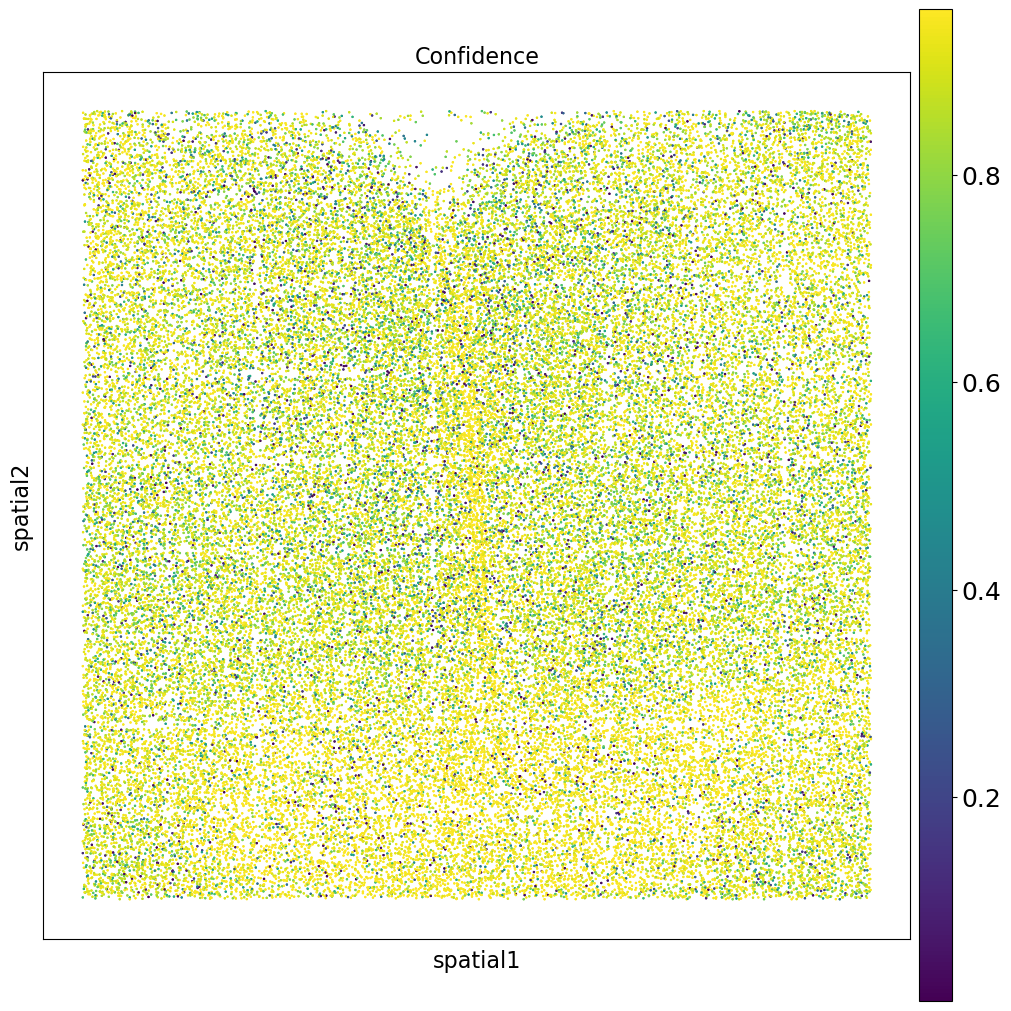

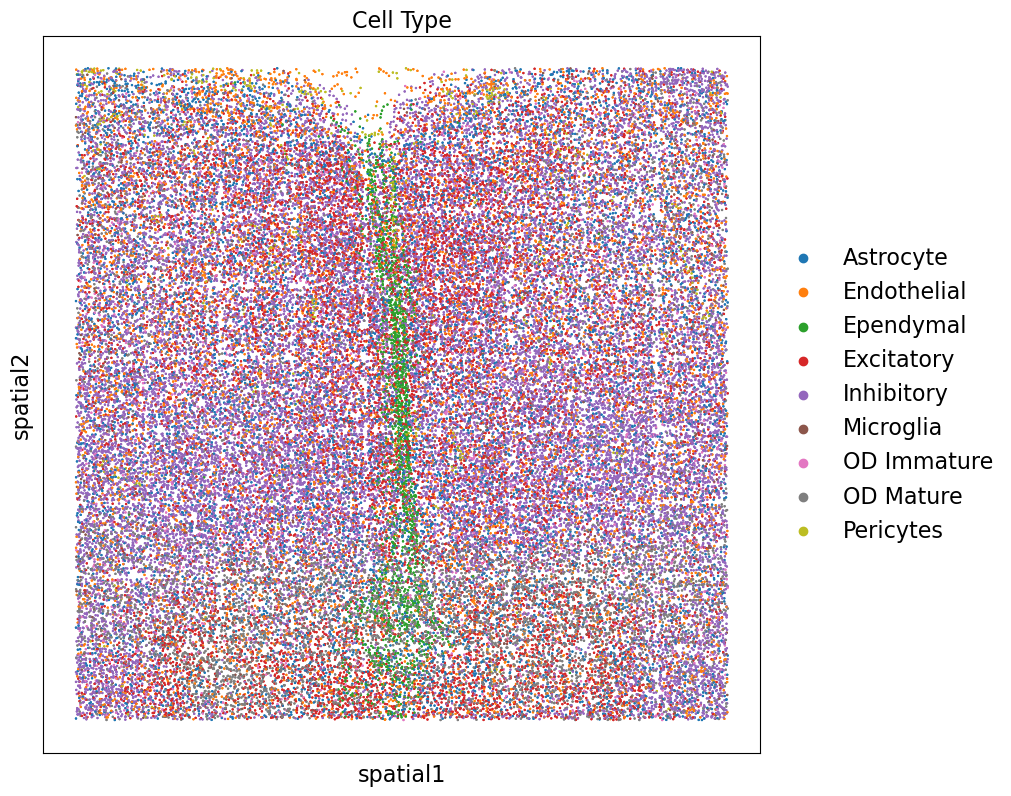

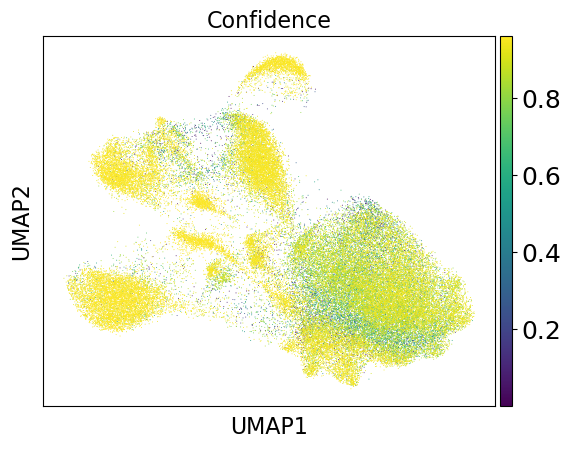

In [14]:
sq.pl.spatial_scatter(
    adata, color=['conf'], shape=None, figsize=(10, 10), title='Confidence',
)
sq.pl.spatial_scatter(
    adata, color=["CellType"], shape=None, figsize=(10, 10),   title='Cell Type',
)
sc.pl.umap(adata,color=['conf'], title='Confidence')

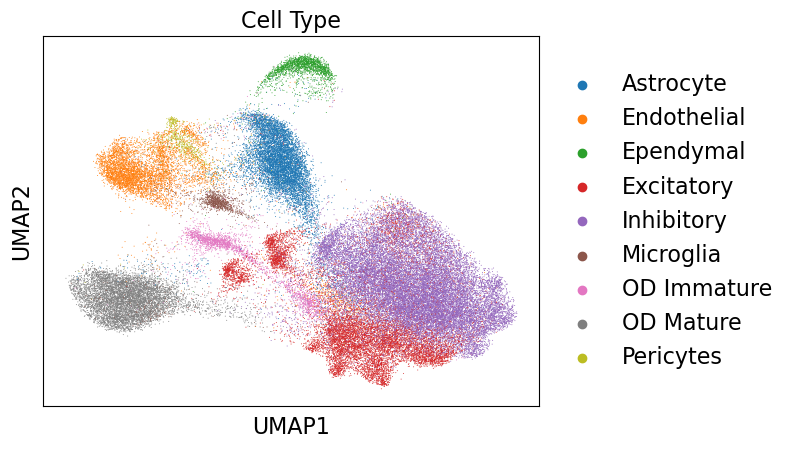

In [15]:
sc.pl.umap(adata,color=["CellType"],   title='Cell Type')


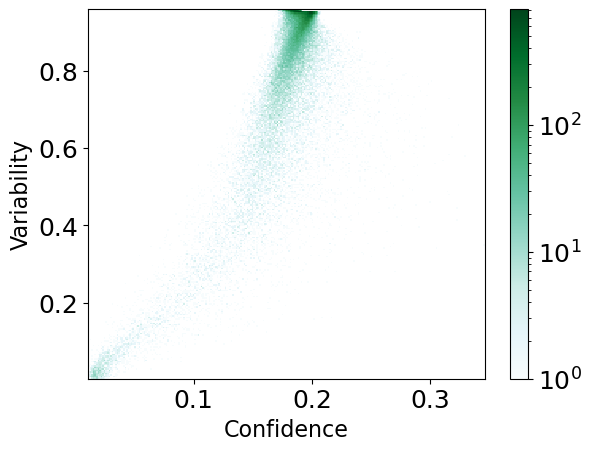

In [16]:
import matplotlib
plt.xlim([0,1])
plt.ylim([0,1])
plt.hist2d(adata.obs['var'], adata.obs['conf'], bins=250, cmap='BuGn',norm=matplotlib.colors.LogNorm())
plt.xlabel('Confidence')
plt.ylabel('Variability')
plt.colorbar()

In [17]:
adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))

adata.obs['conf_binaries'].value_counts()

True     63160
False     1213
Name: conf_binaries, dtype: int64

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


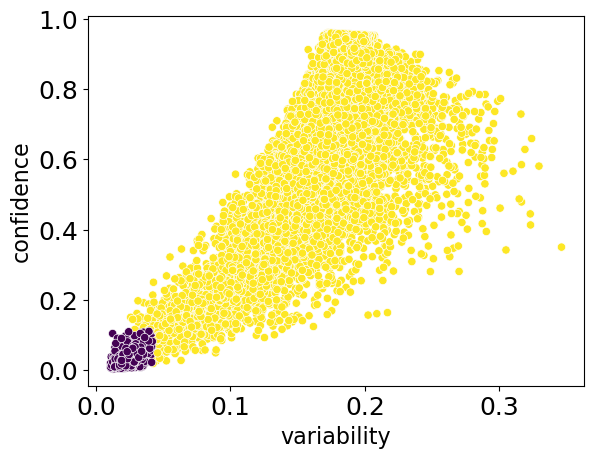

In [18]:
sns.scatterplot( all_var.detach().numpy(),all_conf.detach().numpy(),c=adata.obs['conf_binaries'].astype(int))
plt.xlabel('variability')
plt.ylabel('confidence')
plt.show()


In [19]:

marker_genes_dict = {'Inhibitory neurons':['Gad1'],#, 'Gad2', 'Slc32a1'],
                     'Excitatory neurons': ['Slc17a6'],
                     'Pericytes':['Myh11'],
                     'Endothelial':['Fn1'],
                     'Ependymal':['Cd24a'],
                     'Microglia':['Selplg'],
                     'Astrocytes': ['Aqp4'],
                     'OD Immature': ['Pdgfra'],
                     'OD Mature':['Ttyh2','Mbp']}


marker_genes_list = ['Gad1','Slc17a6',
                     'Myh11',
                     'Fn1',
                     'Cd24a',
                     'Selplg',
                     'Aqp4',
                     'Pdgfra',
                     'Ttyh2','Mbp']



In [20]:
corr_classified_list =[]
for i in range(adata.n_obs):
    if adata.obs['conf_binaries'][i]==True:
        corr_classified_list.append('Correct annotation')
    else: 
        corr_classified_list.append('Erroneous annotation')
adata.obs['annotation']=corr_classified_list
bdata = adata.copy()

sc.pp.scale(bdata)


OD Mature


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


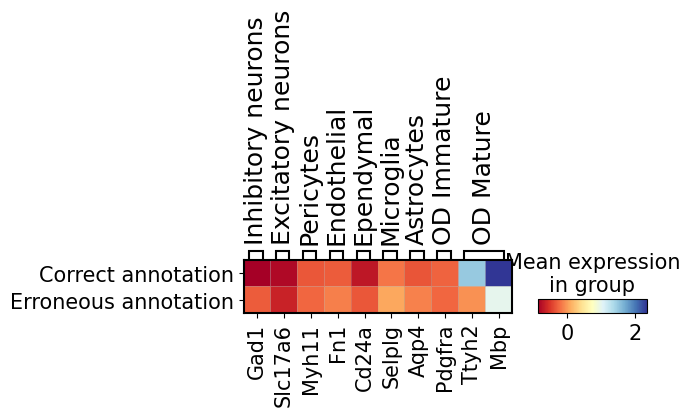

Correct annotation      7056
Erroneous annotation      38
Name: annotation, dtype: int64
OD Immature


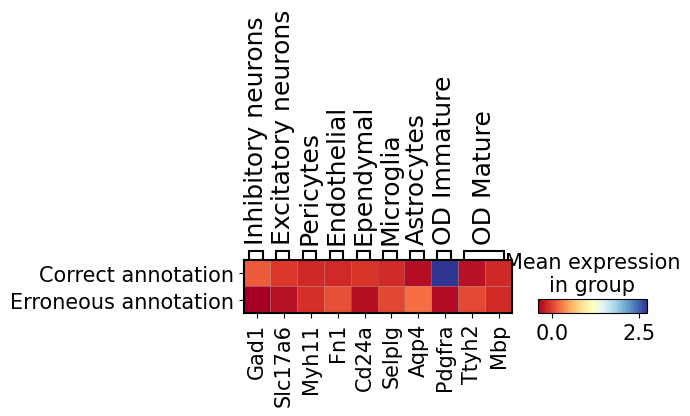

Correct annotation      2509
Erroneous annotation      39
Name: annotation, dtype: int64
Inhibitory


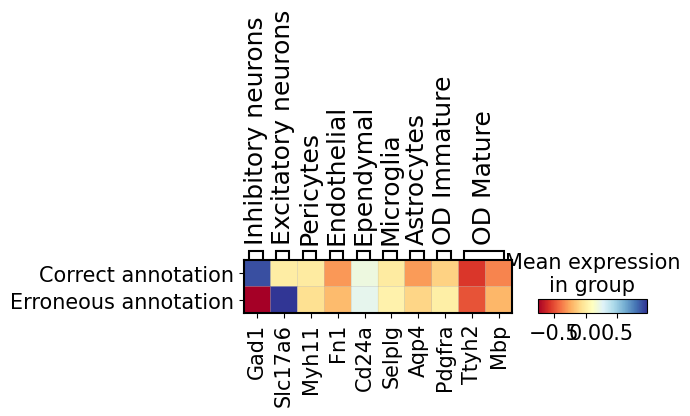

Correct annotation      24034
Erroneous annotation      727
Name: annotation, dtype: int64
Excitatory


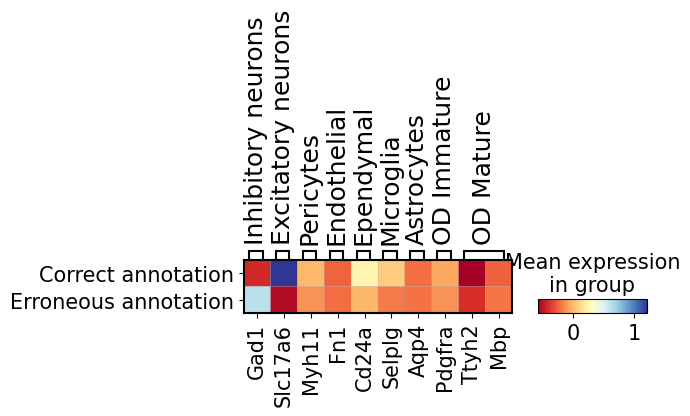

Correct annotation      11498
Erroneous annotation      259
Name: annotation, dtype: int64
Microglia


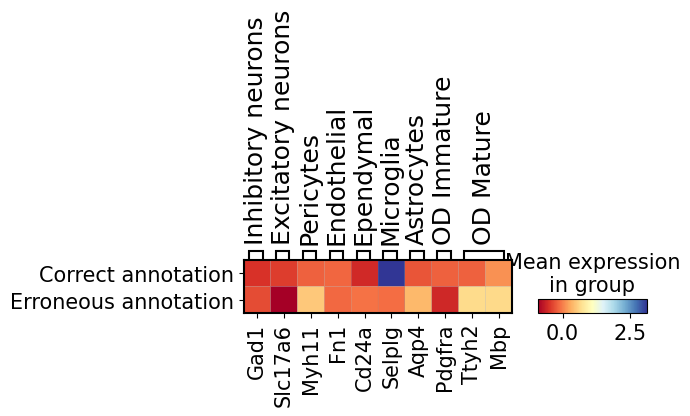

Correct annotation      1465
Erroneous annotation       7
Name: annotation, dtype: int64
Astrocyte


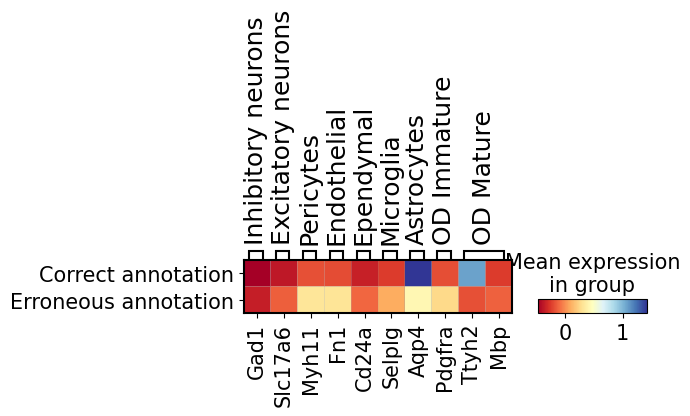

Correct annotation      8318
Erroneous annotation      75
Name: annotation, dtype: int64
Endothelial


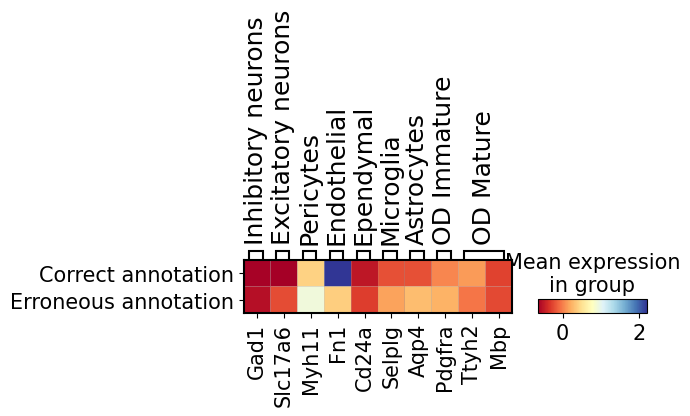

Correct annotation      5682
Erroneous annotation      67
Name: annotation, dtype: int64
Pericytes


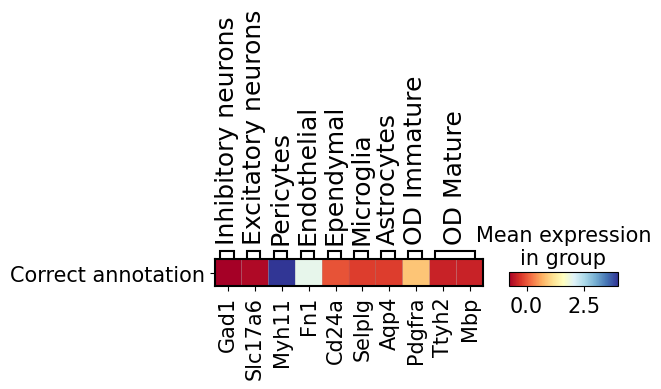

Correct annotation    638
Name: annotation, dtype: int64
Ependymal


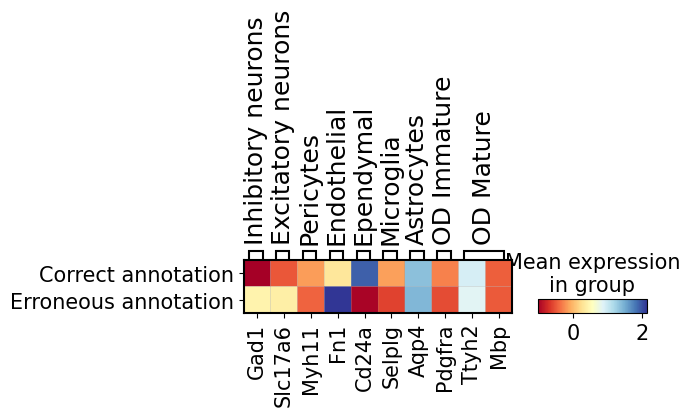

Correct annotation      1960
Erroneous annotation       1
Name: annotation, dtype: int64


In [21]:
celltype_list = adata.obs['CellType'].unique()
for celltype in celltype_list:
    print(celltype)
    adata_tmp= bdata[bdata.obs['CellType'].isin([celltype])]
    ax = sc.pl.matrixplot(adata_tmp, marker_genes_dict, groupby='annotation', cmap='RdYlBu')
    print(adata_tmp.obs['annotation'].value_counts())

In [22]:
bdata= adata[adata.obs['conf_binaries'].isin([True])]
cdata= bdata.copy()
sc.pp.scale(cdata)

In [23]:
hdata = models.predict_true_labels(adata, label='CellType', device=device, epoch_num=20)

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.452
[1,    12] loss: 2.247
[1,    22] loss: 2.217
[1,    32] loss: 2.173
[1,    42] loss: 2.131
[1,    52] loss: 2.093
[1,    62] loss: 2.041
[1,    72] loss: 2.004
[1,    82] loss: 1.948
[1,    92] loss: 1.890
[1,   102] loss: 1.819
[1,   112] loss: 1.746
[1,   122] loss: 1.666
[1,   132] loss: 1.578
[1,   142] loss: 1.487
[1,   152] loss: 1.406
[1,   162] loss: 1.300
[1,   172] loss: 1.201
[1,   182] loss: 1.128
[1,   192] loss: 1.052
[1,   202] loss: 0.960
[1,   212] loss: 0.898
[1,   222] loss: 0.826
[1,   232] loss: 0.763
[1,   242] loss: 0.714
[2,     2] loss: 0.129
[2,    12] loss: 0.645
[2,    22] loss: 0.603
[2,    32] loss: 0.559
[2,    42] loss: 0.546
[2,    52] loss: 0.506
[2,    62] loss: 0.486
[2,    72] loss: 0.484
[2,    82] loss: 0.494
[2,    92] loss: 0.444
[2,   102] loss: 0.428
[2,   112] loss: 0.436
[2,   122] loss: 0.409
[2,   132] loss: 0.391
[2,   142] loss: 0.381
[2,   152] loss: 0.376
[2,   162] loss: 0.373
[2,   172] loss: 0.371
[2,   182] 

[15,    92] loss: 0.141
[15,   102] loss: 0.120
[15,   112] loss: 0.145
[15,   122] loss: 0.131
[15,   132] loss: 0.114
[15,   142] loss: 0.118
[15,   152] loss: 0.127
[15,   162] loss: 0.107
[15,   172] loss: 0.122
[15,   182] loss: 0.124
[15,   192] loss: 0.135
[15,   202] loss: 0.142
[15,   212] loss: 0.116
[15,   222] loss: 0.126
[15,   232] loss: 0.127
[15,   242] loss: 0.124
[16,     2] loss: 0.026
[16,    12] loss: 0.112
[16,    22] loss: 0.139
[16,    32] loss: 0.119
[16,    42] loss: 0.133
[16,    52] loss: 0.121
[16,    62] loss: 0.127
[16,    72] loss: 0.113
[16,    82] loss: 0.133
[16,    92] loss: 0.131
[16,   102] loss: 0.114
[16,   112] loss: 0.126
[16,   122] loss: 0.128
[16,   132] loss: 0.123
[16,   142] loss: 0.127
[16,   152] loss: 0.130
[16,   162] loss: 0.117
[16,   172] loss: 0.144
[16,   182] loss: 0.117
[16,   192] loss: 0.134
[16,   202] loss: 0.115
[16,   212] loss: 0.115
[16,   222] loss: 0.112
[16,   232] loss: 0.132
[16,   242] loss: 0.123
[17,     2] loss

In [24]:
hdata

AnnData object with n_obs × n_vars = 64373 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'modified_label', 'conf_binaries', 'annotation', 'CorrectedCellType'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata_false_annotation= adata[adata.obs['conf_binaries'].isin([False])]

In [26]:
adata_true_annotation= adata[adata.obs['conf_binaries'].isin([True])]

In [27]:
hdata.obs['changed_anno'] = (hdata.obs['CellType']==hdata.obs['CorrectedCellType'])

In [28]:
adata_did_not_changed= hdata[hdata.obs['changed_anno'].isin([True])]
adata_did_not_changed = adata_did_not_changed[adata_did_not_changed.obs['conf_binaries'].isin([False])]
adata_did_not_changed

View of AnnData object with n_obs × n_vars = 0 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'modified_label', 'conf_binaries', 'annotation', 'CorrectedCellType', 'changed_anno'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
adata_annotation_changed= hdata[hdata.obs['changed_anno'].isin([False])]

In [30]:
adata_annotation_changed

View of AnnData object with n_obs × n_vars = 1213 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'modified_label', 'conf_binaries', 'annotation', 'CorrectedCellType', 'changed_anno'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

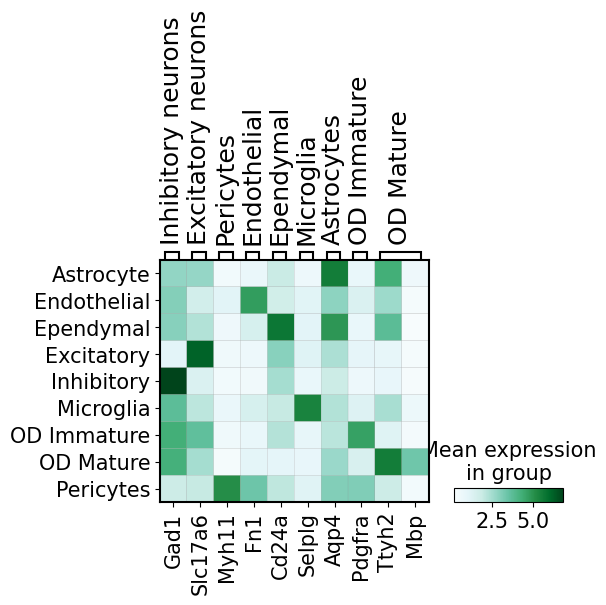

In [31]:
adata_annotation_changed_scaled = adata_annotation_changed.copy()
ax = sc.pl.matrixplot(adata_annotation_changed_scaled, marker_genes_dict, groupby='CorrectedCellType', cmap='BuGn')


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


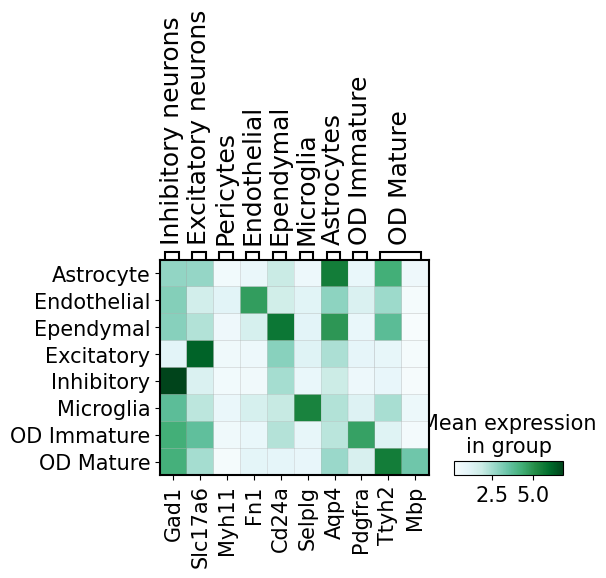

In [32]:
adata_annotation_changed_no_per= adata_annotation_changed[adata_annotation_changed.obs['CorrectedCellType'].isin(['Astrocyte',
                                            'Endothelial', 'Ependymal',
                                            'Excitatory',
                                            'Inhibitory', 'Microglia', 'OD Immature',
                                                                                                         'OD Mature'])]
ax = sc.pl.matrixplot(adata_annotation_changed_no_per, marker_genes_dict, groupby='CorrectedCellType', cmap='BuGn')


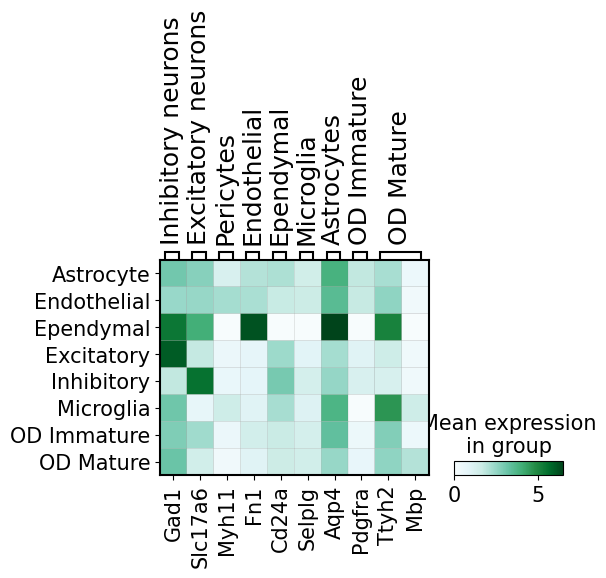

In [33]:
adata_false_annotated= hdata[hdata.obs['conf_binaries'].isin([False])]
ax = sc.pl.matrixplot(adata_false_annotated, marker_genes_dict, groupby='CellType', cmap='BuGn')


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == "__main__":
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


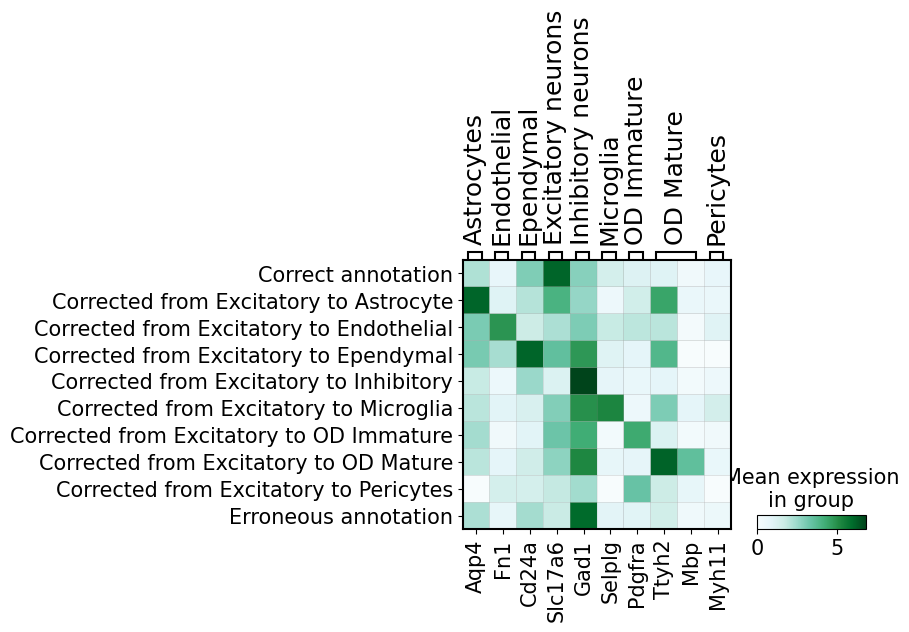

In [34]:
tmp_tdata2 = hdata[hdata.obs['CellType'].isin(['Excitatory'])]
False_or_pos = []
for i in range(tmp_tdata2.n_obs):
    if tmp_tdata2.obs['conf_binaries'][i]:
        False_or_pos.append('Correct annotation')
    else:
        False_or_pos.append('Erroneous annotation')

tmp_tdata2.obs['Celltype_to_corrected'] = False_or_pos


Celltype_to_corrected =[]
for i in range(adata_false_annotated.n_obs):
    string = str(adata_false_annotated.obs['CellType'][i]) + "_" + str(adata_false_annotated.obs['CorrectedCellType'][i])
    Celltype_to_corrected.append(string)
adata_false_annotated.obs['Celltype_to_corrected'] = Celltype_to_corrected

tmp_tdata = adata_false_annotated[adata_false_annotated.obs['CellType'].isin(['Excitatory'])]
Celltype_to_corrected =[]
for i in range(tmp_tdata.n_obs):
        if tmp_tdata.obs['conf_binaries'][i]==False:        
            string = "Corrected from " + str(tmp_tdata.obs['CellType'][i]) + " to " + str(tmp_tdata.obs['CorrectedCellType'][i])
        Celltype_to_corrected.append(string)

tmp_tdata.obs['Celltype_to_corrected'] = Celltype_to_corrected

marker_genes_dict = {
                     'Astrocytes': ['Aqp4'],
                     'Endothelial':['Fn1'],
                     'Ependymal':['Cd24a'],
                     'Excitatory neurons': ['Slc17a6'],
                     'Inhibitory neurons':['Gad1'],#, 'Gad2', 'Slc32a1'],
                     'Microglia':['Selplg'],
                     'OD Immature': ['Pdgfra'],
                     'OD Mature':['Ttyh2','Mbp'],
                     'Pericytes':['Myh11']}

#sc.pl.matrixplot(tmp_tdata3, marker_genes_dict, groupby='Celltype_to_corrected', cmap='RdYlBu')

tmp_tdata3 = tmp_tdata2.concatenate(tmp_tdata)




ax = sc.pl.matrixplot(tmp_tdata3, marker_genes_dict, groupby='Celltype_to_corrected', cmap='BuGn')


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == "__main__":
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


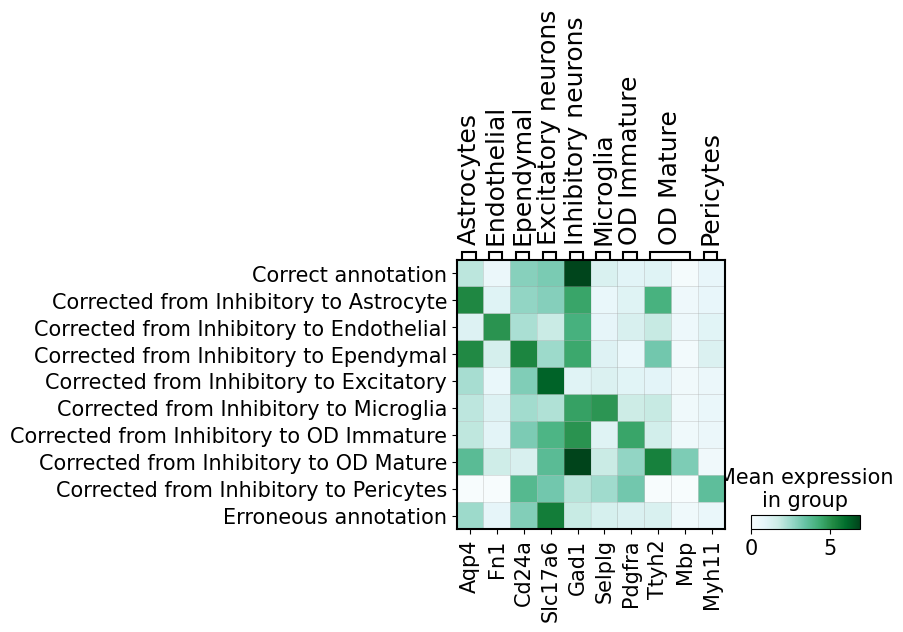

In [35]:
tmp_tdata2 = hdata[hdata.obs['CellType'].isin(['Inhibitory'])]
False_or_pos = []
for i in range(tmp_tdata2.n_obs):
    if tmp_tdata2.obs['conf_binaries'][i]:
        False_or_pos.append('Correct annotation')
    else:
        False_or_pos.append('Erroneous annotation')

tmp_tdata2.obs['Celltype_to_corrected'] = False_or_pos


Celltype_to_corrected =[]
for i in range(adata_false_annotated.n_obs):
    string = str(adata_false_annotated.obs['CellType'][i]) + "_" + str(adata_false_annotated.obs['CorrectedCellType'][i])
    Celltype_to_corrected.append(string)
adata_false_annotated.obs['Celltype_to_corrected'] = Celltype_to_corrected

tmp_tdata = adata_false_annotated[adata_false_annotated.obs['CellType'].isin(['Inhibitory'])]
Celltype_to_corrected =[]
for i in range(tmp_tdata.n_obs):
        if tmp_tdata.obs['conf_binaries'][i]==False:        
            string = "Corrected from " + str(tmp_tdata.obs['CellType'][i]) + " to " + str(tmp_tdata.obs['CorrectedCellType'][i])
        Celltype_to_corrected.append(string)

tmp_tdata.obs['Celltype_to_corrected'] = Celltype_to_corrected

marker_genes_dict = {
                     'Astrocytes': ['Aqp4'],
                     'Endothelial':['Fn1'],
                     'Ependymal':['Cd24a'],
                     'Excitatory neurons': ['Slc17a6'],
                     'Inhibitory neurons':['Gad1'],#, 'Gad2', 'Slc32a1'],
                     'Microglia':['Selplg'],
                     'OD Immature': ['Pdgfra'],
                     'OD Mature':['Ttyh2','Mbp'],
                     'Pericytes':['Myh11']}


tmp_tdata3 = tmp_tdata2.concatenate(tmp_tdata)






ax = sc.pl.matrixplot(tmp_tdata3, marker_genes_dict, groupby='Celltype_to_corrected', cmap='BuGn')


In [36]:
adata_annotation_changed

View of AnnData object with n_obs × n_vars = 1213 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'modified_label', 'conf_binaries', 'annotation', 'CorrectedCellType', 'changed_anno'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
def print_all_mean_expressions(adata,genes_list,label):
    annotations_list = adata.obs[label].unique()
    for gene in genes_list:
        for annotation in annotations_list:
            print("Mean expression of " + gene +" in " + annotation)
            print(get_mean_expression(adata, gene, label,annotation))
def get_mean_expression(adata, gene, label,annotation):
    adata_tmp = (adata[adata.obs[label].isin([annotation])])
    mean_expression = float(np.mean(adata_tmp[:, gene].X.toarray()))
    return mean_expression


In [38]:
print_all_mean_expressions(adata_annotation_changed,marker_genes_list,'CorrectedCellType')

Mean expression of Gad1 in Excitatory
1.0971522331237793
Mean expression of Gad1 in Inhibitory
6.83551025390625
Mean expression of Gad1 in Astrocyte
2.800474166870117
Mean expression of Gad1 in OD Immature
4.31076192855835
Mean expression of Gad1 in Endothelial
3.04327392578125
Mean expression of Gad1 in Pericytes
1.8204541206359863
Mean expression of Gad1 in Microglia
3.7475616931915283
Mean expression of Gad1 in Ependymal
2.9727396965026855
Mean expression of Gad1 in OD Mature
4.260399341583252
Mean expression of Slc17a6 in Excitatory
6.207796573638916
Mean expression of Slc17a6 in Inhibitory
1.3945794105529785
Mean expression of Slc17a6 in Astrocyte
2.756049394607544
Mean expression of Slc17a6 in OD Immature
3.6535849571228027
Mean expression of Slc17a6 in Endothelial
1.6670451164245605
Mean expression of Slc17a6 in Pericytes
1.937915325164795
Mean expression of Slc17a6 in Microglia
2.128021001815796
Mean expression of Slc17a6 in Ependymal
2.275359869003296
Mean expression of Slc17a

In [39]:
print_all_mean_expressions(adata_false_annotation,marker_genes_list,'CellType')

Mean expression of Gad1 in Inhibitory
1.7925704717636108
Mean expression of Gad1 in Excitatory
6.0030341148376465
Mean expression of Gad1 in Astrocyte
3.0558667182922363
Mean expression of Gad1 in Endothelial
2.4377644062042236
Mean expression of Gad1 in OD Immature
2.86214542388916
Mean expression of Gad1 in OD Mature
3.181489944458008
Mean expression of Gad1 in Microglia
3.1213831901550293
Mean expression of Gad1 in Ependymal
5.402202129364014
Mean expression of Slc17a6 in Inhibitory
5.553121089935303
Mean expression of Slc17a6 in Excitatory
1.7356098890304565
Mean expression of Slc17a6 in Astrocyte
2.726689100265503
Mean expression of Slc17a6 in Endothelial
2.4682869911193848
Mean expression of Slc17a6 in OD Immature
2.322122097015381
Mean expression of Slc17a6 in OD Mature
1.4701778888702393
Mean expression of Slc17a6 in Microglia
0.7452133297920227
Mean expression of Slc17a6 in Ependymal
4.029361724853516
Mean expression of Myh11 in Inhibitory
0.6338964700698853
Mean expression of

In [40]:
print_all_mean_expressions(adata_true_annotation,marker_genes_list,'CellType')

Mean expression of Gad1 in OD Mature
1.503161072731018
Mean expression of Gad1 in OD Immature
4.5368547439575195
Mean expression of Gad1 in Inhibitory
6.851898193359375
Mean expression of Gad1 in Excitatory
2.8568928241729736
Mean expression of Gad1 in Microglia
2.579866886138916
Mean expression of Gad1 in Astrocyte
2.679366111755371
Mean expression of Gad1 in Endothelial
2.184182643890381
Mean expression of Gad1 in Pericytes
1.7570804357528687
Mean expression of Gad1 in Ependymal
0.9750599265098572
Mean expression of Slc17a6 in OD Mature
1.0704338550567627
Mean expression of Slc17a6 in OD Immature
2.936938524246216
Mean expression of Slc17a6 in Inhibitory
3.0998337268829346
Mean expression of Slc17a6 in Excitatory
6.116039276123047
Mean expression of Slc17a6 in Microglia
2.0046961307525635
Mean expression of Slc17a6 in Astrocyte
2.124405860900879
Mean expression of Slc17a6 in Endothelial
1.4224793910980225
Mean expression of Slc17a6 in Pericytes
1.3610037565231323
Mean expression of S